# LING 380 Project Naive Bayes Model

### Import Libraries

In [24]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Clean .txt Files and Compile to One DataFrame

In [25]:
def preprocess_text(file_path, file_name):
    with open(file_path, 'r', encoding='utf-8') as file:
        raw_text = file.read()

    sections = re.split(r"(##\d+)", raw_text)
    
    processed_data = []
    
    for i in range(1, len(sections), 2):
        section_id = sections[i].strip()
        content = sections[i + 1].strip() if i + 1 < len(sections) else ""
        
        content = re.sub(r"<[^>]+>", "", content)
        content = re.sub(r"[^\w\s]", "", content) 
        content = re.sub(r"\s+", " ", content) 
        content = content.lower()
        
        processed_data.append({"section_id": section_id, "content": content, "file_name": file_name})
    
    return pd.DataFrame(processed_data)

def process_and_combine(input_folder, output_file):
    all_data = []
    
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        
        if os.path.isfile(file_path) and file_name.endswith(".txt"):
            print(f"Processing file: {file_name}")
            processed_df = preprocess_text(file_path, file_name)
            all_data.append(processed_df)
    
    combined_df = pd.concat(all_data, ignore_index=True)

    combined_df.to_csv(output_file, index=False)
    print(f"All files processed and saved to: {output_file}")

input_folder = "/Users/michaeltoben/Downloads/text"
output_file = "/Users/michaeltoben/Downloads/LING380_project_data.csv"

process_and_combine(input_folder, output_file)

Processing file: w_in_g.txt
Processing file: w_bd_g.txt
Processing file: w_gh_g.txt
Processing file: w_bd_b.txt
Processing file: w_gh_b.txt
Processing file: w_in_b.txt
Processing file: w_tz_g.txt
Processing file: w_za_b.txt
Processing file: w_nz_b.txt
Processing file: w_us_g.txt
Processing file: w_au_b.txt
Processing file: w_ng_g.txt
Processing file: w_au_g.txt
Processing file: w_ng_b.txt
Processing file: w_tz_b.txt
Processing file: w_za_g.txt
Processing file: w_nz_g.txt
Processing file: w_us_b.txt
Processing file: w_ie_g.txt
Processing file: w_ke_b.txt
Processing file: w_ph_b.txt
Processing file: w_sg_b.txt
Processing file: w_lk_g.txt
Processing file: w_my_g.txt
Processing file: w_sg_g.txt
Processing file: w_lk_b.txt
Processing file: w_my_b.txt
Processing file: w_ie_b.txt
Processing file: w_ke_g.txt
Processing file: w_ph_g.txt
Processing file: w_gb_g.txt
Processing file: w_pk_b.txt
Processing file: w_hk_b.txt
Processing file: w_ca_b.txt
Processing file: w_jm_b.txt
Processing file: w_c

### Find Best Model

In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

data = pd.read_csv("/Users/michaeltoben/Downloads/LING380_project_data.csv")
data['file_name'] = data['file_name'].str.extract(r'w_([a-z]{2})_')
allowed_codes = ['us', 'ie', 'au', 'gb', 'ca', 'hk', 'za']
data_clean = data[data['file_name'].isin(allowed_codes)]

avg_accuracies = []

# Loop through n-gram ranges
for i in np.arange(1, 4):
    model_accuracies = []
    print(f"Processing n-grams ranging from 1 to {i}...")

    for j in np.arange(1, 21):
        if j % 5 == 0:
            print(f"Iteration {j} for n-grams ranging from 1 to {i}")

        vectorizer = CountVectorizer(ngram_range=(1, i), max_features=10000)
        X = vectorizer.fit_transform(data_clean['content'])

        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(data_clean['file_name'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

        class_counts = np.bincount(y_train)
        class_priors = class_counts / np.sum(class_counts)

        model = MultinomialNB(class_prior=class_priors)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        model_accuracies.append(np.mean(y_pred == y_test))

    avg_accuracies.append(np.mean(model_accuracies))
    print(f"Average accuracy for n-grams ranging from 1 to {i}: {np.mean(model_accuracies):.4f}")

best_index = np.argmax(avg_accuracies) + 1
print(f"Best accuracy achieved for model using n-grams ranging from 1 to {(best_index)}")
print(f"Accuracy: {np.round(np.max(avg_accuracies), 3)}")
    

Processing n-grams ranging from 1 to 1...
Iteration 5 for n-grams ranging from 1 to 1
Iteration 10 for n-grams ranging from 1 to 1
Iteration 15 for n-grams ranging from 1 to 1
Iteration 20 for n-grams ranging from 1 to 1
Average accuracy for n-grams ranging from 1 to 1: 0.4037
Processing n-grams ranging from 1 to 2...
Iteration 5 for n-grams ranging from 1 to 2
Iteration 10 for n-grams ranging from 1 to 2
Iteration 15 for n-grams ranging from 1 to 2
Iteration 20 for n-grams ranging from 1 to 2
Average accuracy for n-grams ranging from 1 to 2: 0.4092
Processing n-grams ranging from 1 to 3...
Iteration 5 for n-grams ranging from 1 to 3
Iteration 10 for n-grams ranging from 1 to 3
Iteration 15 for n-grams ranging from 1 to 3
Iteration 20 for n-grams ranging from 1 to 3
Average accuracy for n-grams ranging from 1 to 3: 0.3915
Best accuracy achieved for model using n-grams ranging from 1 to 2
Accuracy: 0.409


# Retrain Best Model and Test on Movie Data

In [36]:
vectorizer = CountVectorizer(ngram_range=(1, best_index), max_features=10000)
X = vectorizer.fit_transform(data_clean['content'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data_clean['file_name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

class_counts = np.bincount(y_train)
class_priors = class_counts / np.sum(class_counts)

model = MultinomialNB(class_prior=class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model:")
print(report)

Report for best model:
              precision    recall  f1-score   support

          au       0.41      0.42      0.42        26
          ca       0.18      0.30      0.23        23
          gb       0.39      0.49      0.43        68
          hk       1.00      0.57      0.73         7
          ie       0.24      0.22      0.23        18
          us       0.57      0.35      0.44        68
          za       0.33      0.25      0.29         8

    accuracy                           0.39       218
   macro avg       0.45      0.37      0.39       218
weighted avg       0.43      0.39      0.40       218



### Visualize Findings With Confusion Matrix

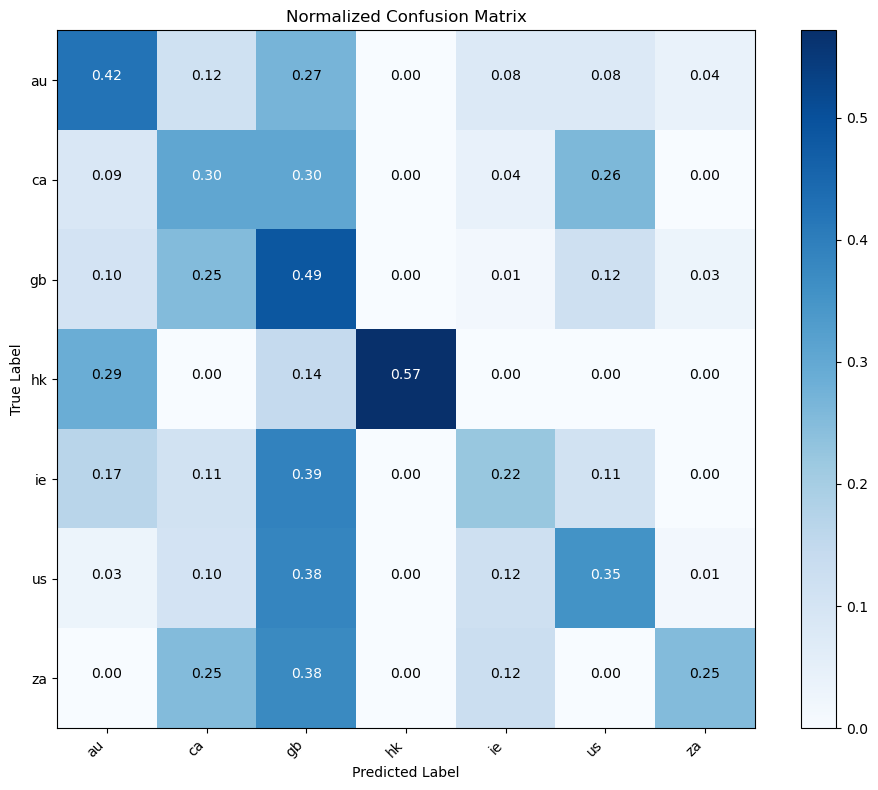

In [37]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()